# Conservation
Exploratory analysis of phyloP scores per region. 

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from scipy import stats
import seaborn as sns

from src import statistics_for_plots as sfp
from src import constants as C

## Data munging

In [2]:
# Read data
df = pd.read_csv("data/interim/phylop_stats_per_region.tsv", sep="\t").pipe(
    sfp.sort_column, labels=C.NMD_REGIONS_DICT
)[
    [
        "symbol",
        "enst",
        "region",
        "constraint",
        "oe_ci_hi",
        "phylop_count",
        "phylop_median",
    ]
]

print(f"Data shape: {df.shape}")
df.head(3)

Data shape: (54969, 7)


,symbol,enst,region,constraint,oe_ci_hi,phylop_count,phylop_median
41445,CIITA,ENST00000324288,NMD target,indeterminate,0.652155,1964,2.3045
50401,AP2S1,ENST00000263270,NMD target,unconstrained,2.080064,127,6.2730
30626,NAT10,ENST00000257829,NMD target,unconstrained,1.068992,2769,6.2720


In [3]:
# Drop NaNs
df = df.dropna()
print(f"Data shape after dropping NaNs: {df.shape}")

Data shape after dropping NaNs: (54937, 7)


In [4]:
# Drop genes symbols with multiple ENST IDs
print(f"Unique gene symbols: {df.symbol.nunique()}")
print(f"Unique ensts: {df.enst.nunique()}\n")

_uniq_symbol_enst = df[["symbol", "enst"]].drop_duplicates()
_symbol_dups = _uniq_symbol_enst.duplicated("symbol").sum()

print(
    f"There are {_symbol_dups} symbols with multiple transcripts.",
    "They are dropped.\n",
)

_kept_symbols = _uniq_symbol_enst["symbol"].drop_duplicates(keep=False)
df = df[df["symbol"].isin(_kept_symbols)].set_index("symbol")

print(f"Remaining unique gene symbols: {df.index.nunique()}")
print(f"Remaining unique ENSTs: {df.enst.nunique()}")

Unique gene symbols: 18352
Unique ensts: 18357

There are 5 symbols with multiple transcripts. They are dropped.

Remaining unique gene symbols: 18347
Remaining unique ENSTs: 18347


In [5]:
# Assign percentiles
df["oe_ci_hi_pct"] = df.groupby(["region"])["oe_ci_hi"].rank(method="min", ascending=False, pct=True)
df["phylop_median_pct"] = df.groupby(["region"])["phylop_median"].rank(method="min", ascending=True, pct=True)
df["pct_delta"] = df["oe_ci_hi_pct"] - df["phylop_median_pct"]

df.sample(5).sort_values(["region","oe_ci_hi"])

,enst,region,constraint,oe_ci_hi,phylop_count,phylop_median,oe_ci_hi_pct,phylop_median_pct,pct_delta
symbol,,,,,,,,,
VMP1,ENST00000262291,NMD target,constrained,0.165148,877,6.235,0.990382,0.783136,0.207246
CFAP251,ENST00000288912,NMD target,indeterminate,0.888774,3137,1.761,0.646169,0.158897,0.487272
HSDL1,ENST00000219439,Start proximal,unconstrained,1.790393,150,6.333,0.577211,0.957367,-0.380156
PPIL2,ENST00000398831,Start proximal,unconstrained,2.172888,150,6.247,0.374398,0.872432,-0.498034
PHACTR3,ENST00000371015,Distal,indeterminate,2.273131,63,6.249,0.213089,0.830708,-0.617619


## Find weakly conserved, strongly constrained regions

Filter for constrained regions with weak phyloP scores.

In [6]:
m1 = df["phylop_median_pct"] < 0.1
m2 = df["oe_ci_hi_pct"] > 0.9
m3 = df["constraint"] == "constrained"

lo_hi = df[m1 & m2 & m3]

print(
    f"Weakly conserved and strongly constrained transcript counts per region:\n"
    f"{lo_hi.groupby('region').size()}"
)

Weakly conserved and strongly constrained transcript counts per region:
region
NMD target        6
Start proximal    1
Long exon         5
Distal            9
dtype: int64


In [7]:
lo_hi.sort_values(["region","oe_ci_hi_pct"], ascending=False)

,enst,region,constraint,oe_ci_hi,phylop_count,phylop_median,oe_ci_hi_pct,phylop_median_pct,pct_delta
symbol,,,,,,,,,
DCAF4L1,ENST00000333141,Distal,constrained,0.335876,1038,0.4300,0.992543,0.075018,0.917525
MDM4,ENST00000367182,Distal,constrained,0.349602,617,0.5600,0.991597,0.097112,0.894485
ZNF473,ENST00000270617,Distal,constrained,0.385392,2437,0.3870,0.988369,0.069898,0.918471
NANOG,ENST00000229307,Distal,constrained,0.431487,464,0.4590,0.983472,0.081752,0.901720
ZNF469,ENST00000565624,Distal,constrained,0.460619,11709,0.2480,0.979131,0.049307,0.929824
PEG3,ENST00000326441,Distal,constrained,0.461917,3952,0.5265,0.978964,0.092493,0.886471
ZNF738,ENST00000683779,Distal,constrained,0.526772,856,0.0490,0.970727,0.020814,0.949914
PPP1R26,ENST00000356818,Distal,constrained,0.542464,3477,0.3370,0.968446,0.064277,0.904168
ATMIN,ENST00000299575,Distal,constrained,0.545984,1857,0.4600,0.967722,0.083254,0.884468


Many of these regions are poorly covered, and therefore have strong oe_ci_95 scores, but have an "indeterminate" constraint annotation.
It will be sensible to filter for constrained regions only.

One example is the last exon of NANOG (ENST00000229307, OE95=0.43, mean phyloP=0.2).
This appears to be a mammalian expansion of the CDS. 
The highly conserved homeodomains occur in two smaller internal exons.
A quick scan of the literature suggests that the C-terminal domain of human NANOG contains two highly potent transactivating domains.
Although these lack any homology or structural resemblance to known domains and are poorly modelled by alphafold.

? Immune genes e.g. CFH (ENST00000367429), PTPRC (ENST00000442510), 

Non-conserved long-exon region of ICE1

The central exons of TCOF (Treacher-Collins Syndrome) are poorly conserved.

The start-proximal region of USP17L2 is strongly constrained but weakly conserved.

Four ZNF proteins have strong distal constraint but weak conservation.
(But they don't look particularly interesting.)

**Jamie flags CFH as a flagship gene at the interface between rare and common eye disorders.**

## Find the strongest outliers in each region

In [8]:
constrained = df[df["constraint"] == "constrained"]
constrained.groupby("region")["pct_delta"].nlargest(5)

region          symbol 
NMD target      FAS        0.943828
                TCOF1      0.902982
                CCNE1      0.900994
                PTPRC      0.881116
                SYCP2      0.861366
Start proximal  USP17L2    0.996678
                LSP1       0.855545
                ZNF33B     0.718509
                ARID3B     0.679807
                RNF6       0.665356
Long exon       MUC5B      0.961937
                ICE1       0.888855
                MTUS2      0.881547
                ZNF407     0.871803
                TACC3      0.856882
Distal          ZNF738     0.949914
                ZNF469     0.929824
                ZNF473     0.918471
                DCAF4L1    0.917525
                PPP1R26    0.904168
Name: pct_delta, dtype: float64

ARID3B looks an interesting case. It has a long first exon which is lowly conserved, but totally depleted for nonsense variants in gnomAD.
The remainder of the CDS is more highly conserved.

Similarly RNF6. The first two coding exons have regions of weak conservation, but are totally depleted for nonsense or frameshift variants.



## Distribution of centiles
It will be interesting to look at the deviation between constraint and conservation within each region.
For example, distal regions seem enriched among regions with the strongest constraint but weakest conservation (above).
Is this a general property, or just something we see in a handful of examples?

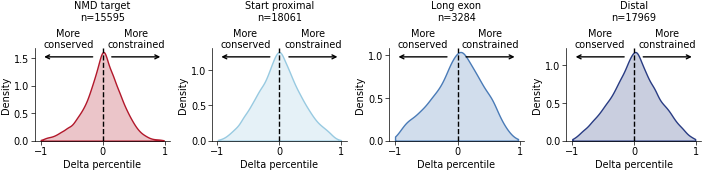

In [9]:
plt.style.use([C.STYLE_DEFAULT, C.COLOR_REGIONS])


def standard_figure(**kwargs):
    kwargs.setdefault("nrows", 1)
    kwargs.setdefault("ncols", 4)
    kwargs.setdefault("figsize", (18 * C.CM, 4.5 * C.CM))
    kwargs.setdefault("layout", "constrained")

    return plt.subplots(**kwargs)


fig, axs = standard_figure()

for ax, (name, group), color in zip(axs, df.groupby("region"), sns.color_palette()[1:]):
    # Look at phyloP medians here...
    statistic = group["oe_ci_hi_pct"] - group["phylop_median_pct"]

    sns.kdeplot(ax=ax, x=statistic, color=color, fill=True, cut=0)

    ax.set_xlabel("Delta percentile")
    ax.set_title(f"{name}\nn={len(group)}", pad=20)
    ax.axvline(x=statistic.mean(), color="black", ls="--")

    # Annotations for clarity
    ax.annotate(
        "",
        xy=(0.05, 0.9),
        xytext=(0.45, 0.9),
        xycoords="axes fraction",
        arrowprops=dict(arrowstyle="->"),
    )
    ax.annotate(
        "More\nconserved",
        xy=(0.25, 1),
        xytext=(0.25, 1),
        textcoords="axes fraction",
        ha="center",
        ma="center",
    )

    ax.annotate(
        "",
        xy=(0.95, 0.9),
        xytext=(0.55, 0.9),
        xycoords="axes fraction",
        arrowprops=dict(arrowstyle="->"),
    )
    ax.annotate(
        "More\nconstrained",
        xy=(0.75, 1),
        xytext=(0.75, 1),
        textcoords="axes fraction",
        ha="center",
        ma="center",
    )

There is no glaring difference between the regions

NMD target summary statistics:
DescribeResult(nobs=2214, minmax=(-0.16742545687720423, 0.9438281500480923), mean=0.17177942806466645, variance=0.040557804791719984, skewness=0.955124951334584, kurtosis=0.4894587578152114)

Start proximal summary statistics:
DescribeResult(nobs=101, minmax=(0.0028791318310170677, 0.9966779248103649), mean=0.2079553285044467, variance=0.0436406962645519, skewness=1.5277432264718271, kurtosis=1.9010272923497542)

Long exon summary statistics:
DescribeResult(nobs=394, minmax=(-0.1151035322777102, 0.9619366626065774), mean=0.3178964924537984, variance=0.06330173883989064, skewness=0.35745953950671, kurtosis=-0.8592475057470366)

Distal summary statistics:
DescribeResult(nobs=612, minmax=(-0.03361344537815125, 0.9499137403305693), mean=0.28835281677922436, variance=0.05338660510958908, skewness=0.8450753256061223, kurtosis=-0.11770636792515576)



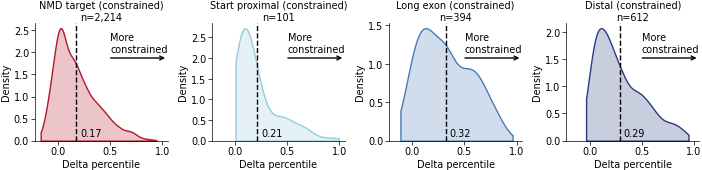

In [10]:
fig, axs = standard_figure(sharex=True)

for ax, (name, group), color in zip(axs, df.groupby("region"), sns.color_palette()[1:]):
    # Limit to constrained regions
    group = group[group["constraint"] == "constrained"]

    # Look at phyloP medians here...
    statistic = group["oe_ci_hi_pct"] - group["phylop_median_pct"]

    print(
        f"{name} summary statistics:\n{stats.describe(statistic, nan_policy='omit')}\n"
    )
    sns.kdeplot(ax=ax, x=statistic, color=color, fill=True, cut=0)

    ax.annotate(
        "",
        xy=(1, 0.7),
        xytext=(0.55, 0.7),
        xycoords="axes fraction",
        arrowprops=dict(arrowstyle="->"),
    )
    ax.annotate("More\nconstrained", xy=(1, 0.75), xytext=(1,0.75), textcoords="axes fraction", ha="right", ma="left")

    ax.set_xlabel("Delta percentile")
    ax.set_title(f"{name} (constrained)\nn={len(group):,}")

    ax.axvline(statistic.mean(), color="black", ls="--")
    ax.annotate(f"{statistic.mean():.2}", xy=(statistic.mean(),0), xytext=(3, 3), textcoords="offset points")

Constrained long exon and distal regions have higher mean delta percentile.
These plots could be expressed as box and whiskers.
Significance could be test with a T test.

The high level trend appears to be that constrained regions have positive percentile differences.
But this is an artefact of selecting for constrained regions only. 
In these regions, there is only one direction in which conserved values can go if they are to be different from constrained values.

## Comparing raw scores

First, create scatter plots of constraint vs phyloP raw scores.

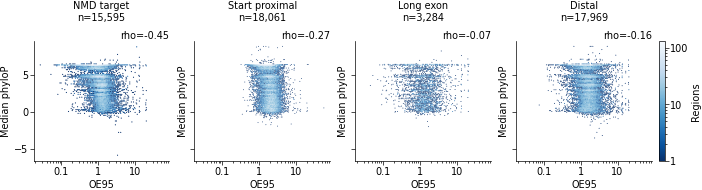

In [11]:
def hexbin_plot(x, y, ax=None, **kwargs):
    kwargs.setdefault("xscale", "log")
    kwargs.setdefault("bins", "log")
    kwargs.setdefault("cmap", "Blues_r")
    # kwargs.setdefault("edgecolors", "none")
    kwargs.setdefault("linewidths", 0)
    
    ax = ax or plt.gca()

    hb = ax.hexbin(
        x,
        y,
        **kwargs,
    )

    return hb


def customise_hexbin(x, y, title, ax=None):
    ax = ax or plt.gca()

    ax.set_xlabel("OE95")
    ax.set_ylabel("Median phyloP")
    ax.set_title(f"{title}\nn={len(x):,}", pad=15)

    rho = stats.spearmanr(x, y).statistic
    ax.annotate(
        f"rho={rho:.2f}",
        xy=(1, 1),
        xycoords=("axes fraction"),
        ha="right",
        va="bottom",
        ma="right",
    )

    return ax


fig, axs = standard_figure(figsize=(18 * C.CM, 5 * C.CM), sharex=True, sharey=True)

for ax, (name, group) in zip(axs, df.groupby("region")):
    x = group["oe_ci_hi"]
    y = group["phylop_median"]

    hb = hexbin_plot(x, y, ax)
    customise_hexbin(x, y, name, ax)

    # Simplify the tick marks
    ax.xaxis.set_major_formatter('{:g}'.format)

cb = fig.colorbar(hb, ax=axs[3], label="Regions", format=ticker.ScalarFormatter())

Constraint in long exon and distal regions is less strongly correlated with conservation.

What about in constrained regions only?

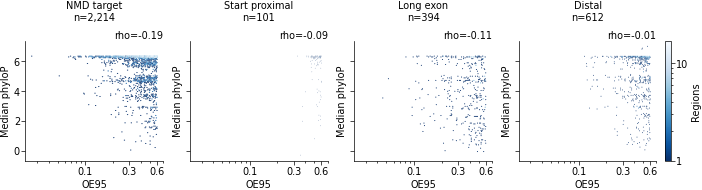

In [12]:
fig, axs = standard_figure(figsize=(18 * C.CM, 5 * C.CM), sharex=True, sharey=True)

for ax, (name, group) in zip(axs, df.groupby("region")):
    # Subset to constrained regions only
    group = group[group.constraint == "constrained"]
    
    x = group["oe_ci_hi"]
    y = group["phylop_median"]

    hb = hexbin_plot(x, y, ax)
    customise_hexbin(x, y, name, ax)

    # Simplify the tick marks
    ax.xaxis.set_major_locator(ticker.FixedLocator([0.1, 0.3, 0.6]))
    ax.xaxis.set_major_formatter("{:g}".format)

cb = fig.colorbar(hb, ax=axs[3], label="Regions", format=ticker.ScalarFormatter())

The story is less clearcut, but again distal regions correlate most poorly.

Perhaps comparing percentiles in constrained regions will be clearer?

## Comparing percentile scores 

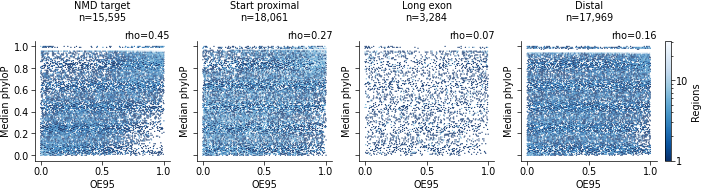

In [13]:
fig, axs = standard_figure(figsize=(18 * C.CM, 5 * C.CM), sharex=True, sharey=True)

for ax, (name, group) in zip(axs, df.groupby("region")):
   
    x = group["oe_ci_hi_pct"]
    y = group["phylop_median_pct"]

    hb = hexbin_plot(x, y, ax, xscale="linear", bins="log")
    customise_hexbin(x, y, name, ax)

cb = fig.colorbar(hb, ax=axs[3], label="Regions", format=ticker.ScalarFormatter())

No clear trend emerges, because the rank normalised scores are uniformly distributed.

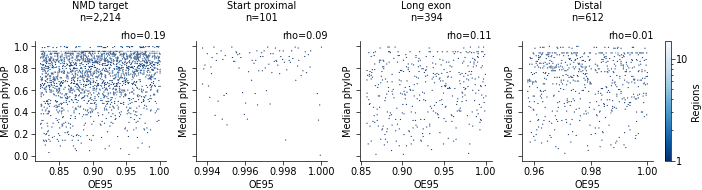

In [15]:
fig, axs = standard_figure(figsize=(18 * C.CM, 5 * C.CM), sharey=True)

for ax, (name, group) in zip(axs, df.groupby("region")):
    # Subset to constrained regions only
    group = group[group.constraint == "constrained"]
       
    x = group["oe_ci_hi_pct"]
    y = group["phylop_median_pct"]

    hb = hexbin_plot(x, y, ax, xscale="linear", bins="log")
    customise_hexbin(x, y, name, ax)

cb = fig.colorbar(hb, ax=axs[3], label="Regions", format=ticker.ScalarFormatter())

It's also not a particularly clear message after subsetting to constrained genes.

## Normalisation to find outliers

## Conclusion
Of the genes prioritised with this approach, NANOG looks the most interesting.
There is no regional pattern for divergence between constraint and phylop scores on aggregate.
But for constrained regions, long exon and distal regions tend to have greater disparity between constraint and conservation. 

## To do
- [X] Distributions of constraint  / median conservation percentile deltas, per region
- [ ] Highlight outliers with the smallest "sum of percentiles" - maybe 5-10 genes in each region.